# Multi Armed Bandit Problem

## Problem Description

Imagine you are at a casino, and you have N slot machines to play, each slot machine gives rewards according to a fixed probability distribution. What strategy should you play with to maximise your total reward ?

This problem is known as [Multi Armed Bandit](https://en.wikipedia.org/wiki/Multi-armed_bandit) problem.

In [1]:
# Importing numpy for math, and matplotlib for plots
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Arms

An arm when pulled, gives a random number from a normal distribution with fixed mean(mu) and deviation(sigma).
When pulled many times the frequency of the rewards look like this:

![normal distribution](https://upload.wikimedia.org/wikipedia/commons/thumb/7/74/Normal_Distribution_PDF.svg/350px-Normal_Distribution_PDF.svg.png)
X axis is the magnitude of reward  
Y axis is it's frequency.

The Arm class provides an arm with these properties.

In [2]:
class Arm:

    def __init__(self, mu="NULL", sigma="NULL"):
        if mu=="NULL":
            mu=np.absolute(np.random.uniform())
        if sigma=="NULL":
            sigma=np.absolute(np.random.uniform())
        
        self.mu = mu
        self.sigma = sigma

    def pull(self):
        reward = np.random.normal(self.mu, self.sigma, 1)
        return reward


def get_arms(k):
    # returns a list of arms
    arms = []
    for i in range(k):
        arms.append(Arm())
    return arms


## Agents

An agent here is a player who pulls arms to play.
It has a policy, which is a list of probabilities associated with each arm.


The agent class makes designing agents **fast**. The object is initialised with arms and whether it should play all arms once as part of the initialisation.

Features provided by this class:  
Attributes:
* expectations[i]: gives the expected reward on playing arm[i]
* times_played[i]: gives the number of times the agent has played arm[i]
* N = Total number of times agent has played
* reward_history : list of rewards earned by the agent
* choice_history : list of choices made by the agent  

Methods:
* gamble(i): Plays for i iterations while updating it's policy.
* play(i): Pulls arm[i] and updates reward_history, N , times_played
* select_arm(): returns index of an arm by sampling  probability distribution given by the policy


In [3]:
class agent:
    def __init__(self, arms, play_once=1):
        self.expectations = np.zeros(len(arms))
        self.times_played = np.zeros(len(arms))
        self.arms = arms

        self.number_of_arms = len(arms)
        self.N = 0

        self.reward_history = []
        self.choice_history = []

        if play_once == 1:
            for i in range(self.number_of_arms):
                self.expectations[i] = self.play(i)

    def play(self, index):
        reward = self.arms[index].pull()

        self.times_played[index] += 1
        self.N += 1

        self.choice_history.append(index)
        self.reward_history.append(reward)

        return reward

    def policy(self):
        pass

    def update_expectations(self, reward, index):
        self.expectations[index] += (reward - self.expectations[index])/self.N

    def select_arm(self):
        options = range(self.number_of_arms)
        i = np.random.choice(options, p=self.policy(), replace=False)
        return i

    def gamble(self, iterations):
        for i in range(iterations):
            index = self.select_arm()
            reward = self.play(index)
            self.update_expectations(reward, index)


### Example agents

To make a new agent we [inherit]() the agent class.

Time to make some agents! 

### First up: epsilon-greedy

This agent plays the arm with the highest expected reward with _1 - epsilon_ probability, and plays a random arm with _epsilon_ probability

So  
    epsilon = 1 => random choices  
    epsilon = 0 => greedy choices 
    
    



In [4]:
class epsilon_greedy(agent):

    def __init__(self, arms, play_once=1, epsilon=0.1):
        super().__init__(arms, play_once)
        self.epsilon = epsilon
        
    def __str__(self):
        return "Epsilon-Greedy Agent, epsilon= "+str(self.epsilon)
    
    def policy(self):
        temp = np.zeros_like(self.expectations)
        temp[np.argmax(self.expectations)] = 1-self.epsilon
        ans = temp + self.epsilon/self.number_of_arms
        return ans

### Beta-Softmax

This agent plays an arm[i] with probability proportional to: e^(expected_reward(arm[i])/beta)  
We normalise the whole thing by the sum over all the arms.


In [5]:
class softmax(agent):

    def __init__(self, arms, play_once=1, beta=1):
        super().__init__(arms, play_once)
        self.beta = beta
        
    def __str__(self):
        return "Softmax agent, beta= "+ str(self.beta)

    def policy(self):
        temp = np.exp(self.expectations/self.beta)
        ans = temp / np.sum(temp, axis=0)
        return ans

### Upper Confidence Bound (UCB1)

UCB1 agent plays the arm with the highest metric, where metric of arm i is :
metric[i] = expected_reward[i] + sqrt(2*log(N)/times_played[i])

__Note__ Best peformance when rewards are between 0 and 1

In [6]:
class ucb(agent):

    def __init__(self, arms, play_once=1):
        super().__init__(arms, play_once)

    def __str__(self):
        return "UCB1 agent"
    
    def policy(self):
        temp = self.expectations + np.sqrt(2*np.log(self.N)/self.times_played)
        ans = np.zeros_like(temp)
        ans[np.argmax(temp)] = 1
        return ans

## Metrics

Metric : A scalar number, makes comparison easier.  
To compare the performance of our agents we can use these metrics

* avg_reward[i] : this gives the average reward till i+1  iteration.
* max_reward : this tells us the maximum expected reward

* euclid_distance : we can think of as learnt policy and optimal policy as vectors and compute the distance between them , smaller is better 
* cosine_simmilarity : compute the cos(q) between the policies. larger is better

In [7]:
def maxreward(arms):
    #Max rewards
    a= [arm.mu for arm in arms]
    return max(a)

def avg_reward(rewards):
    ans = []
    ans.append(rewards[0])
    for i in range(1,len(rewards)):
        ans.append(ans[i-1]+rewards[i])
    for i in range(len(ans)):
        ans[i]/=i+1
    return ans

def cosine_similarity(a,b):
    temp = a*b
    temp/=(euclid_distance(a)* euclid_distance(b))
    return np.sum(temp, axis=0)
    
def euclid_distance(a):
    return np.sqrt(np.sum(a*a, axis=0))

### Test

This function takes a list of agents and the number of iterations. Makes each agent play, and prints its metrics.

In [8]:
def test(agents, iterations):
    for agent in agents:
        
        agent.gamble(iterations)
        
        temp = [ arm.mu for arm in levers] 
        optimal_policy = np.zeros_like(agent.expectations)
        optimal_policy[temp.index(max(temp))] = 1
        
        avg_rewards_earned = avg_reward(agent.reward_history)
        
        print(agent)
        print("maximum possible reward:", maxreward(levers))
        print("average reward:", avg_rewards_earned[-1])
        print("cosine similarity" ,cosine_similarity(agent.policy(), optimal_policy))
        euclid_norm = euclid_distance(agent.policy()-optimal_policy)/len(optimal_policy)
        print("euclidian norm ",euclid_norm)
        
        
        plt.plot(avg_rewards_earned)
        plt.ylabel('Average Reward')
        plt.xlabel('Iteration')
        plt.show()
        print("\n")
    
        # print("optimal policy:" , optimal)
        # print("learnt policy:" ,agent.policy())
        
    
        
        # plt.scatter(range(len(agent.choice_history)),y=agent.choice_history)
        # plt.title("Choices")
        # plt.xlabel("time")
        # plt.ylabel("arm")
        # plt.show()
        # print("\n")
    
    

In [9]:
levers = get_arms(10)

agents = [
    epsilon_greedy(levers, epsilon=1),
    epsilon_greedy(levers, epsilon=0),
    softmax(levers, beta=0.1),
    ucb(levers)

]


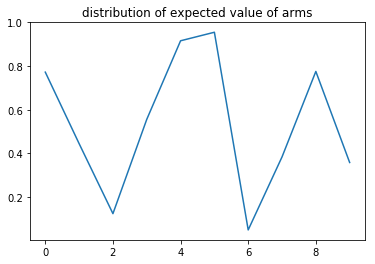

In [10]:
plt.plot([ arm.mu for arm in levers] )
plt.title("distribution of expected value of arms")

Epsilon-Greedy Agent, epsilon= 1
maximum possible reward: 0.95526462917
average reward: [ 0.53399883]
cosine similarity 0.316227766017
euclidian norm  0.0948683298051


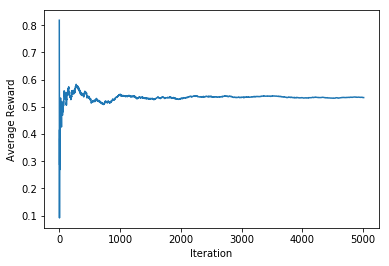



Epsilon-Greedy Agent, epsilon= 0
maximum possible reward: 0.95526462917
average reward: [ 0.95084623]
cosine similarity 1.0
euclidian norm  0.0


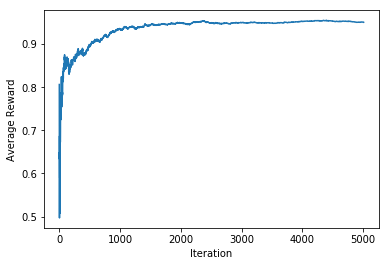



Softmax agent, beta= 0.1
maximum possible reward: 0.95526462917
average reward: [ 0.87857076]
cosine similarity 0.805661424116
euclidian norm  0.0627859490132


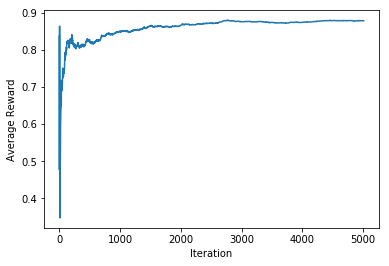



UCB1 agent
maximum possible reward: 0.95526462917
average reward: [ 0.73588045]
cosine similarity 0.0
euclidian norm  0.141421356237


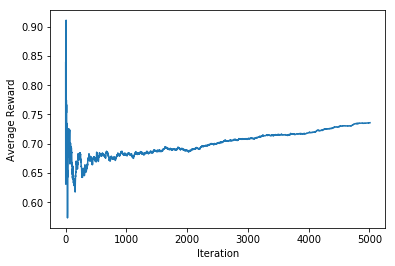

In [11]:
test(agents, 5000)


### Experimental stuff:

Below are a few agents I wrote for fun.

In [12]:

class softmax_with_exponentiation(agent):

    def __init__(self, arms, play_once=1, beta=1, exp=1):
        super().__init__(arms, play_once)
        self.beta = beta
        self.exp = exp

    def policy(self):
        temp = np.exp(self.expectations/self.beta)
        ans = temp / np.sum(temp, axis=0)
        ans = ans**self.exp
        ans /= np.sum(ans, axis=0)
        return ans


class softmax_with_reccurence(agent):

    def __init__(self, arms, play_once=1, beta=1):
        super().__init__(arms, play_once)
        self.old_policy = np.ones_like(self.expectations)/self.l
        self.beta = beta

    def policy(self):
        temp = np.exp(self.expectations/self.beta)
        new_policy = temp / np.sum(temp, axis=0)

        result = np.multiply(new_policy, self.old_policy)
        result /= np.sum(result, axis=0)
        self.old_policy = result

        return result


class greedy_with_reccurence(agent):
    # alpha = number < 1; will sum over a number of observations and will keep
    # osiclating.
    # alpha = N will allow the algo to converge to an arm, greedy doesn't
    # really need this, kind of always give one answer.

    def __init__(self, arms, play_once=1, alpha=1):
        super().__init__(arms, play_once)
        self.old_policy = np.ones_like(self.expectations)
        self.alpha = alpha

    def policy(self):
        new_policy = np.zeros_like(self.expectations)
        new_policy[np.argmax(self.expectations)] = 1

        new_policy = (1-self.alpha)*new_policy + self.alpha*self.old_policy

        new_policy /= np.sum(new_policy, axis=0)
        self.old_policy = new_policy

        return new_policy

# class magic(agent):
#    def __init__(self, arms, play_once=1, exp=1):
#        super().__init__(arms, play_once)
#        self.old_policy = np.ones_like(self.expectations)/self.l
#        self.exp = exp
#
#    def policy(self):
#        new_policy = f(old_policy, g(expectations))
